In [81]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn.models import VGAE
from torch_geometric.loader import DataLoader
import numpy as np
import json
import os
from core.utils import * 
from core.datasetclass import LinearElasticityDataset
from core.model import *
from core.normalization import Normalizer
import matplotlib.pyplot as plt
from tqdm import tqdm

from dolfinx import fem, io, default_scalar_type, mesh
from dolfinx.fem.petsc import LinearProblem
from mpi4py import MPI
import ufl
import meshio
import numpy as np
import pandas as pd

In [82]:
mesh_file = "/home/narupanta/ADDMM/parameter_identification/tensile_test_specimen2.msh"
domain, mesh_tags, facet_tags = io.gmshio.read_from_msh(mesh_file, MPI.COMM_WORLD, 0)

def FEM_Solution(domain, mesh_file, facet_tags, G, K) :
    # Import Geometry
    mesh = meshio.read(mesh_file)
    fdim = domain.topology.dim - 1
    domain.topology.create_connectivity(fdim, domain.topology.dim)
    V = fem.functionspace(domain, ("Lagrange", 1, (3,)))

    # Define Dirichlet Boundary Condition (Dirichelet BC is defined at the facet 3)
    b_D = fem.locate_dofs_topological(V, fdim, facet_tags.find(3))
    u_D = np.array([0, 0, 0], dtype=default_scalar_type)
    bc_D = fem.dirichletbc(u_D, b_D, V)

    # Define Neumann Boundary Condition
    T_neuman = fem.Constant(domain, default_scalar_type((106.26e6, 0, 0 )))
    ds = ufl.Measure("ds", domain=domain, subdomain_data=facet_tags)

    # Define Weak form
    def epsilon(u):
        return ufl.sym(ufl.grad(u))  # Equivalent to 0.5*(ufl.nabla_grad(u) + ufl.nabla_grad(u).T)
    
    def sigma(u):
        return  (-2/3 * G + K) * ufl.nabla_div(u) * ufl.Identity(len(u)) + 2 * G * epsilon(u)
    
    # Define Trial and Test Function
    u = ufl.TrialFunction(V)
    v = ufl.TestFunction(V)

    # Include Load into the system (the facet for Neumann Boundary is set at facet 4)
    f = fem.Constant(domain, default_scalar_type((0, 0, 0)))
    a = ufl.inner(sigma(u), epsilon(v)) * ufl.dx
    L = ufl.dot(f, v) * ufl.dx + ufl.dot(T_neuman, v) * ds(4)

    # Create Solver (Linear)
    problem = LinearProblem(a, L, bcs=[bc_D], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})

    # Solve
    uh = problem.solve()
    
    # Post Processing (Retrieve solution in the dataset's domain)
    x_origin_sub = [20e-3, 100e-3]
    y_origin_sub = 10e-3

    domain_arr = domain.geometry.x
    print(domain_arr.shape)
    print(mesh.points.shape)
    subdomain_condition = (domain_arr[:, 0] >= x_origin_sub[0]) & (domain_arr[:, 0] <= x_origin_sub[1]) # Extract x-coordinates and apply condition
    
    num_dofs = V.dofmap.index_map.size_local
    uh_arr = uh.x.array[:].reshape((num_dofs, -1))
    def get_uh_with_coords(positions, features, query_positions) :
        """
        Return the features corresponding to the given query positions.

        Parameters:
        - positions: A 2D NumPy array of shape (n, d) representing the positions.
        - features: A NumPy array of shape (n, m) containing the features at each position.
        - query_positions: A 2D NumPy array of shape (k, d) representing the positions to query.

        Returns:
        - A NumPy array of shape (k, m) containing the features corresponding to the query positions.
        """
        # Find indices of the query positions in the positions array
        indices = np.where((positions[:, None] == query_positions).all(axis=2))[1]
        
        # Return the corresponding features
        return features[indices]

    # Get the subdomain for using with the data
    domain_sub = domain_arr[subdomain_condition]
    for cell in mesh.cells:
        if cell.type == 'triangle' :
            triangles = cell.data
    domain_sub[:, 0] -= x_origin_sub[0]
    domain_sub[:, 1] += y_origin_sub
    u_sub = uh_arr[subdomain_condition]

    return mesh.points, triangles, get_uh_with_coords(mesh.points, uh_arr, domain_arr), uh_arr, domain_sub, u_sub

Info    : Reading '/home/narupanta/ADDMM/parameter_identification/tensile_test_specimen2.msh'...
Info    : 28 entities
Info    : 467 nodes
Info    : 852 elements
Info    : Done reading '/home/narupanta/ADDMM/parameter_identification/tensile_test_specimen2.msh'


In [2]:
dataset = LinearElasticityDataset(data_dir = "./dataset")
print("number of trajectories: ", len(dataset))
print(dataset[0])

def preprocessing(data, meta, return_mean_std):
    """
    Custom preprocessing for normalization.
    Args:
        data (Data): A single PyG graph object.
    Returns:
        Data: Preprocessed graph object.
    """
    G_tensor = torch.tensor(meta['G_list']).reshape(-1, 1)
    K_tensor = torch.tensor(meta['K_list']).reshape(-1, 1)
    material_list = torch.cat((G_tensor, K_tensor), dim = 1)
    materials_mean = material_list.mean(dim = 0)
    materials_std = material_list.std(dim = 0)
    # Normalize node features (min-max scaling as an example)
    # if hasattr(data, 'mesh_pos') and data.mesh_pos is not None:
    #     if return_mean_std :
    #         data.mesh_pos, mean_mesh_pos, std_mesh_pos= normalize(data.mesh_pos, True)
    #     else :
    #         data.mesh_pos = normalize(data.mesh_pos, False)
    # if hasattr(data, 'gt_displacement') and data.gt_displacement is not None:
    #     if return_mean_std :
    #         data.gt_displacement, mean_gt_disp, std_gt_disp = normalize(data.gt_displacement, True)
    #     else :
    #         data.gt_displacement = normalize(data.gt_displacement, False)
    if hasattr(data, 'material_params') and data.material_params is not None:
        data.material_params = (data.material_params - materials_mean)/materials_std
    if return_mean_std :
        return data, materials_mean, materials_std
    else :
        return data
prep_dataset = [preprocessing(data, dataset.meta, False) for data in dataset][:850]

number of trajectories:  925
Data(edge_index=[2, 2574], mesh_pos=[467, 2], triangles=[820, 3], material_params=[467, 2], gt_displacement=[467, 2])


/home/narupanta/ADDMM/surrogate_model/core/datasetclass.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  triangles = torch.tensor(torch.tensor(data['node_connectivity']))


  0%|          | 0/850 [00:00<?, ?it/s]

Epoch 1/20, Loss: 0.3906276845055468


Epoch 2/20, Loss: 0.24817468098857823


Epoch 3/20, Loss: 0.2385087337213404


Epoch 4/20, Loss: 0.2358708162255147


Epoch 5/20, Loss: 0.24063493087887763


Epoch 6/20, Loss: 0.2409313658142791


Epoch 7/20, Loss: 0.2350687958913691


Epoch 8/20, Loss: 0.24251452251392253


Epoch 9/20, Loss: 0.2399411136350211


Epoch 10/20, Loss: 0.23496277919586966


Epoch 11/20, Loss: 0.2392102234591456


Epoch 12/20, Loss: 0.24284982577842826


Epoch 13/20, Loss: 0.2348077040823067


Epoch 14/20, Loss: 0.23967376486343495


Epoch 15/20, Loss: 0.2355021912210128


Epoch 16/20, Loss: 0.23720585555714718


Epoch 17/20, Loss: 0.2397015163740691


Epoch 18/20, Loss: 0.23688194624641362


Epoch 19/20, Loss: 0.25914733471239315


Epoch 20/20, Loss: 0.23815368099247708


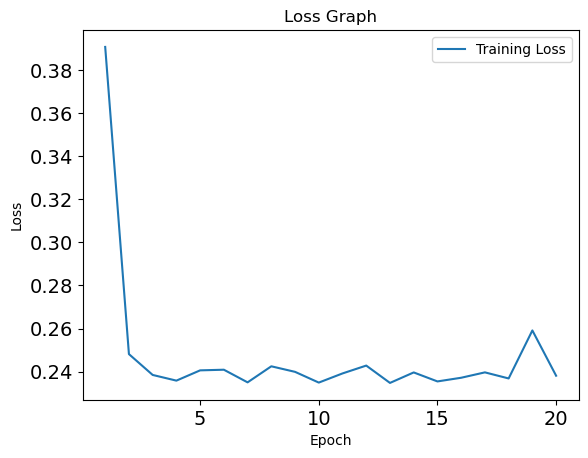

In [83]:
train_loader = DataLoader(prep_dataset, batch_size=1, shuffle = False)
# Model, optimizer, and loss function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_dim = 2
hidden_dim = 256
latent_dim = 512
output_dim = 2  # Predict scalar nodal values
material_dim = 2

encoder = Encoder(input_dim, hidden_dim, latent_dim, material_dim)
decoder = GraphDecoder(latent_dim, output_dim, material_dim)
model = CVGAEWithDeformationDecoder(encoder, decoder)
model = model.to(device)

# Optimizer Setup
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-3)

# Training loop
num_epochs = 20
loss_values = []

model.train()
for epoch in range(num_epochs):
    total_loss = 0
    loop = tqdm(enumerate(train_loader), total = len(train_loader), leave = False)
    for idx_traj, batch in loop:
        batch = batch.to(device)
        optimizer.zero_grad()
        predictions = model(batch, True)

        loss = model.loss(predictions, batch, beta = 1e-4)

        # Backpropagation
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        # print(f"Trajectory {idx_traj}/{len(train_loader)}, Loss: {loss:.4f}")
        loop.set_description(f"trajectory {idx_traj + 1}/{len(train_loader)}")
        loop.set_postfix(loss = loss)
    
    avg_loss = total_loss / len(train_loader)
    loss_values.append(avg_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss}")

# Plot loss graph
plt.plot(range(1, num_epochs + 1), loss_values, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [5]:
data_interpolate, material_mean, material_std = preprocessing(dataset[0], dataset.meta, True)
data_extrapolate, material_mean, material_std = preprocessing(dataset[890], dataset.meta, True)

/home/narupanta/ADDMM/surrogate_model/core/datasetclass.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  triangles = torch.tensor(torch.tensor(data['node_connectivity']))


In [6]:
edge_index_int = data_interpolate.edge_index.to(device)
material_params_int = data_interpolate.material_params.to(device)
edge_index_ext = data_extrapolate.edge_index.to(device)
material_params_ext = data_extrapolate.material_params.to(device)

latent_space = model.latent_space.to(device)
edge_index = model.edge_index.to(device)
normalized_predict_interpolate = model.decode(latent_space, edge_index_int, material_params_int).squeeze()
normalized_predict_extrapolate = model.decode(latent_space, edge_index_ext, material_params_ext).squeeze()

In [76]:
def predict_deformation(model, material_params, meta, device) :
    # Prepare the input for model
    latent_space = model.latent_space.to(device)
    edge_index = model.edge_index.to(device)
    mesh_pos = model.mesh_pos.to(device)
    triangles = model.triangles.to(device)
    output_normalizer = model._output_normalizer
    # Normalize Material Parameters
    G_tensor = torch.tensor(meta['G_list']).reshape(-1, 1)
    K_tensor = torch.tensor(meta['K_list']).reshape(-1, 1)
    material_list = torch.cat((G_tensor, K_tensor), dim = 1)
    materials_mean = material_list.mean(dim = 0)
    materials_std = material_list.std(dim = 0)
    normalize_material_params = (material_params - materials_mean)/materials_std
    material_params_tensor = normalize_material_params.repeat(latent_space.shape[0], 1).to(device)

    normalized_predicted_deformation = model.decode(latent_space, edge_index, material_params_tensor).squeeze()
    predicted_deformation = output_normalizer.inverse(normalized_predicted_deformation)
    return mesh_pos, triangles, predicted_deformation

In [77]:
mesh_pos, triangles, predicted_deformation = predict_deformation(model, torch.tensor([7.224e+10, 9.169e+10]), dataset.meta, device)

In [78]:
fem_pos, _, u, _, _, _ = FEM_Solution(domain, mesh_file, facet_tags, 7.224e+10, 9.169e+10)
fem_deformation = u [:, :2]


(467, 3)
(467, 3)


In [79]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
def plot_result_compare_FEM(mesh_pos, triangles, predictions, fem_result) :
    # Get node coordinates
    nodes = mesh_pos.cpu().detach().numpy()  # Extract the x, y coordinates (for 2D)
    predictions_plot = predictions.cpu().detach().numpy()
    plotdata = {"predicted displacement" : predictions_plot, "FEM displacement" : fem_result, "error field" : np.abs(predictions_plot - fem_result)}
    # Get connectivity for triangular elements
    # normalized_mat_params = data.material_params[0].cpu() 
    # material_parameters = normalized_mat_params * matstd + matmean
    # Plotting
    triangulation = tri.Triangulation(nodes[:, 0], nodes[:, 1], triangles.cpu())

    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(24, 6))  # 2 row, 3 columns

    # First subplot
    for key, v in plotdata.items() :
        for j in range(2) :
            i = list(plotdata.keys()).index(key)
            if key != "error field" :
                im = axes[j][i].tripcolor(triangulation, plotdata[key][:, j], shading='flat', cmap='viridis')
            else :
                im = axes[j][i].tripcolor(triangulation, plotdata[key][:, j], shading='flat', cmap='viridis')
            axes[j][i].triplot(triangulation, color='black', linewidth=0.5)
            if j == 0 :
                axes[j][i].set_title(f"{key} X")
            else :
                axes[j][i].set_title(f"{key} Y")
            axes[j][i].set_xlabel("X-coordinate")
            axes[j][i].set_ylabel("Y-coordinate")
            fig.colorbar(im, ax=axes[j][i], orientation='vertical', label="Nodal Value")
    # fig.suptitle(material_parameters.detach().numpy(), fontsize=16)
    plt.tight_layout()
    plt.show()

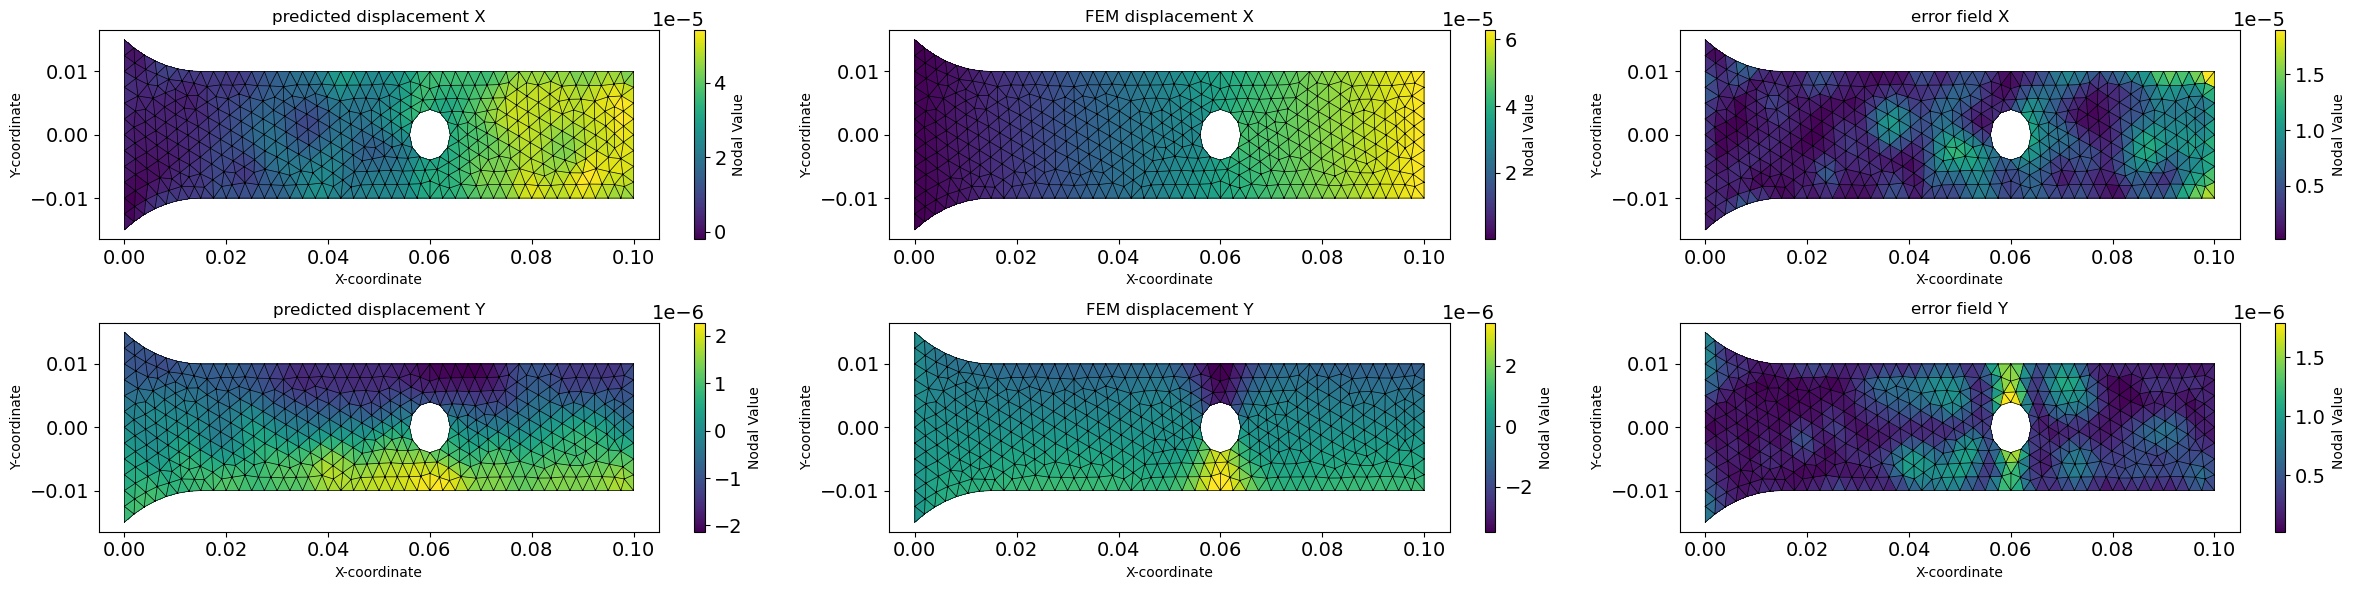

In [80]:
plot_result_compare_FEM(mesh_pos, triangles, predicted_deformation, fem_deformation)

[0.00000000e+00 1.87810718e-05 6.15784420e-05 1.87810718e-05
 4.72401517e-05 3.23567722e-05 2.06090066e-05 2.17439614e-05
 2.16638049e-05 2.21931553e-05 2.38697140e-05 2.34677177e-05
 2.44247943e-05 1.86504510e-05 2.44832499e-05 3.05385581e-05
 3.59205979e-05 2.88112525e-05 2.73550552e-05 3.55062294e-05
 3.80328964e-05 3.75501448e-05 3.95856000e-05 3.80347051e-05
 4.44598134e-05 4.35198331e-05 4.66861140e-05 4.59684817e-05
 5.02891862e-05 4.98758112e-05 4.93455905e-05 4.88153697e-05
 4.93455905e-05 4.90804801e-05 4.93455905e-05 5.31748522e-05
 5.71776292e-05 6.10984862e-05 6.10888109e-05 6.09901107e-05
 6.19344888e-05 6.12077333e-05 6.17160349e-05 6.12399884e-05
 6.01432100e-05 5.94590028e-05 5.77142926e-05 5.71305426e-05
 5.54298379e-05 5.38915742e-05 5.32030308e-05 5.12727126e-05
 5.19836714e-05 4.89956440e-05 4.83486225e-05 4.66228477e-05
 4.65381549e-05 4.31164216e-05 4.23856208e-05 3.97439313e-05
 3.96404043e-05 4.00372886e-05 3.79344527e-05 3.46622679e-05
 3.34205026e-05 3.197697

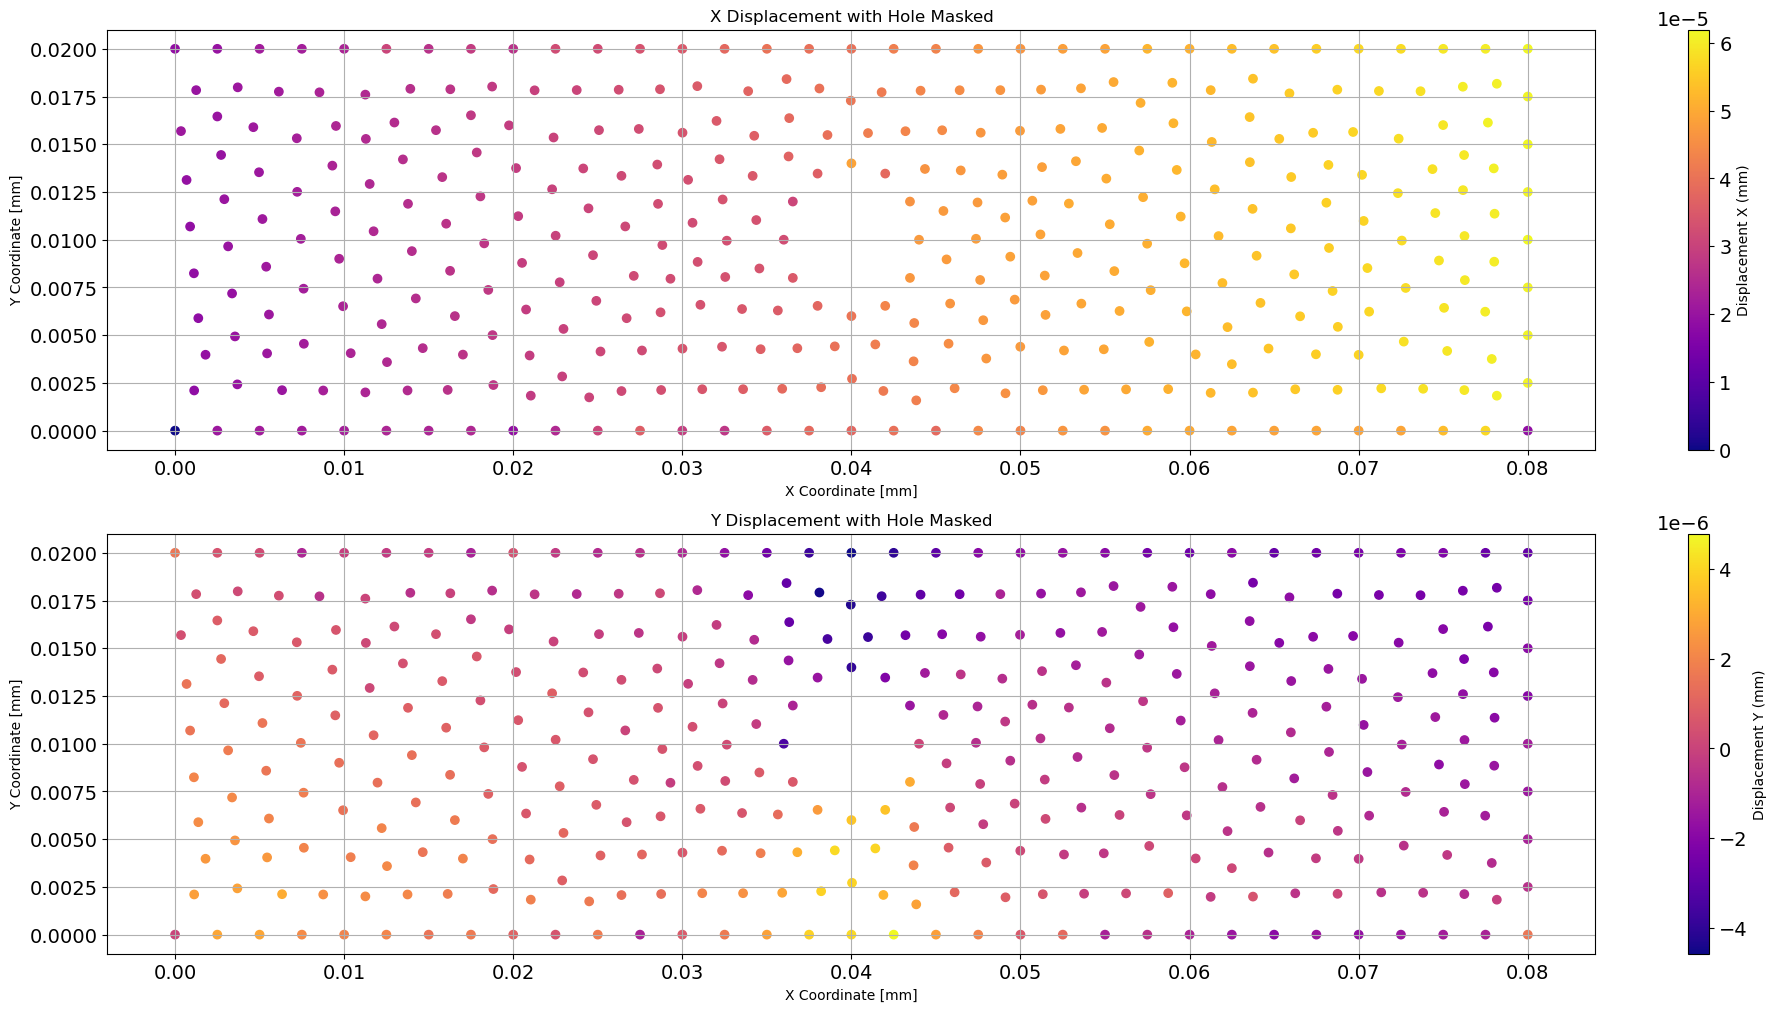

In [46]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
from scipy.interpolate import griddata
raw = True
if raw:
    df = pd.read_csv(r"/home/narupanta/ADDMM/parameter_identification/11257192/20231116_displacements_raw.csv")
else :
    df = pd.read_csv(r"/home/narupanta/ADDMM/parameter_identification/11257192/20231116_displacements_interpolated.csv")
def remove_outliers_zscore(df, columns, threshold=3):
    """
    Removes outliers from specified columns in a DataFrame using the Z-score method.

    Parameters:
    - df: DataFrame from which to remove outliers.
    - columns: List of column names to check for outliers.
    - threshold: Z-score threshold to determine outliers (default is 3).

    Returns:
    - Cleaned DataFrame with outliers removed.
    """
    cleaned_df = df.copy()

    for column in columns:
        # Calculate the mean and standard deviation
        mean = cleaned_df[column].mean()
        std = cleaned_df[column].std()

        # Calculate the Z-score for each value in the column
        z_scores = (cleaned_df[column] - mean) / std

        # Filter out outliers based on the Z-score threshold
        cleaned_df = cleaned_df[(np.abs(z_scores) <= threshold)]

    return cleaned_df
def fill_na_with_neighbors(flattened_image, shape):
    rows, cols = shape
    for i in range(1, len(flattened_image) - 1):
        if np.isnan(flattened_image[i]):
            # Get the row and column indices of the pixel in the 2D image
            row = i // cols
            col = i % cols

            # Get the neighbors (left, right, top, bottom) in the flattened array
            neighbors = []
            if col > 0:  # Left neighbor
                neighbors.append(flattened_image[i - 1])
            if col < cols - 1:  # Right neighbor
                neighbors.append(flattened_image[i + 1])
            if row > 0:  # Top neighbor
                neighbors.append(flattened_image[i - cols])
            if row < rows - 1:  # Bottom neighbor
                neighbors.append(flattened_image[i + cols])

            # Remove NaN values from the neighbors list
            neighbors = [val for val in neighbors if not np.isnan(val)]

            # If there are valid neighbors, replace the NaN with the mean
            if neighbors:
                flattened_image[i] = np.mean(neighbors)
    
    return flattened_image

def mask_hole(X, Y) :
    center_x, center_y = 40e-3, 10e-3
    radius = 4e-3

    # Calculate the distance of each point from the center of the circle
    distance_from_center = np.sqrt((X - center_x)**2 + (Y - center_y)**2)

    # Create a mask: True for points outside the circle, False for points inside
    return distance_from_center >= radius
def get_displacement_at_point(df, x, y, isClearOutlier):
    """
    Interpolates displacement data at a specified (x, y) point.

    Parameters:
    - df: DataFrame with columns ['x', 'y', 'displacement_x', 'displacement_y'].
    - x: float, x-coordinate of the point to interpolate.
    - y: float, y-coordinate of the point to interpolate.
    - method: Interpolation method (default is 'linear').

    Returns:
    - interpolated_displacement_x: Interpolated displacement_x value at the specified point.
    - interpolated_displacement_y: Interpolated displacement_y value at the specified point.
    """
    if isClearOutlier :
        df = remove_outliers_zscore(df, ['x-displacement [mm]', "y-displacement [mm]"], 3)
    # Extract points and displacement values from the DataFrame
    points = df[['x-coordinate [mm]', 'y-coordinate [mm]']].values/1000
    displacement_x = df['x-displacement [mm]'].values/1000
    displacement_y = df['y-displacement [mm]'].values/1000
    # Create interpolators for displacement_x and displacement_y
    interp_x = fill_na_with_neighbors(griddata(points, displacement_x, (x, y), method='linear'), points.shape)
    interp_y = fill_na_with_neighbors(griddata(points, displacement_y, (x, y), method='linear'), points.shape)
    # interp_x = griddata(points, displacement_x, (x, y), method='linear')
    # interp_y = griddata(points, displacement_y, (x, y), method='linear')
    interp_x[np.isnan(interp_x)] = 0
    interp_y[np.isnan(interp_y)] = 0
    return interp_x, interp_y
x_origin_sub = [20e-3, 100e-3]
y_origin_sub = 10e-3
subdomain_condition = (fem_pos[:, 0] >= x_origin_sub[0]) & (fem_pos[:, 0] <= x_origin_sub[1])
fem_pos_sub = fem_pos[subdomain_condition]
x_sub = fem_pos_sub[:, 0] - x_origin_sub[0]
y_sub = fem_pos_sub[:, 1] + y_origin_sub
X, Y = x_sub, y_sub
mask = mask_hole(X, Y)
Z_x = get_displacement_at_point(df, X, Y, True)[0]
Z_y = get_displacement_at_point(df, X, Y, True)[1]
print(Z_x)
# X_train, Y_train =  np.where(mask, X, np.nan), np.where(mask, Y, np.nan)
# Z_x_train = np.where(mask, Z_x, np.nan)
# Z_y_train = np.where(mask, Z_y, np.nan)
# # Plotting the mesh
fig, ax = plt.subplots(2, 1, figsize=(24, 12))
print(np.max(Z_x))
# # # Subplot for displacement_x
contour_x = ax[0].scatter(X, Y , c = Z_x , cmap='plasma')
cbar_x = fig.colorbar(contour_x, ax=ax[0], label='Displacement X (mm)')
ax[0].set_title('X Displacement with Hole Masked')
ax[0].set_xlabel('X Coordinate [mm]')
ax[0].set_ylabel('Y Coordinate [mm]')
ax[0].grid(True)

# Subplot for Y displacement
contour_y = ax[1].scatter(X, Y , c = Z_y , cmap='plasma')
cbar_y = fig.colorbar(contour_y, ax=ax[1], label='Displacement Y (mm)')
ax[1].set_title('Y Displacement with Hole Masked')
ax[1].set_xlabel('X Coordinate [mm]')
ax[1].set_ylabel('Y Coordinate [mm]')
ax[1].grid(True)
# Display the plots
plt.show()

In [74]:
from scipy.optimize import minimize
def callback(xk):
    print(f"Current solution: {xk}")

class OptimizationHistory:
    def __init__(self):
        self.history = []

    def __call__(self, xk):
        # Save current parameter values
        self.history.append(xk.copy())
def mse_loss(model, train_ds, BETA) :
    G, K = BETA
    mesh_pos, triangles, predicted_deformation = predict_deformation(model, torch.tensor([G, K], dtype = torch.float32), dataset.meta, device)
    x_origin_sub = [20e-3, 100e-3]
    y_origin_sub = 10e-3
    subdomain_condition = (mesh_pos[:, 0] >= x_origin_sub[0])
    mesh_pos_sub = mesh_pos[subdomain_condition]
    x_sub = mesh_pos_sub[:, 0] - x_origin_sub[0]
    y_sub = mesh_pos_sub[:, 1] + y_origin_sub
    predicted_deformation_sub = predicted_deformation[subdomain_condition]
    ux_sub = predicted_deformation_sub[:, 0].cpu().detach().numpy()
    uy_sub = predicted_deformation_sub[:, 1].cpu().detach().numpy()
    train_disp_x = train_ds[:, 2]
    train_disp_y = train_ds[:, 3]
    mean_disp_x = np.mean(np.absolute(train_disp_x))
    mean_disp_y = np.mean(np.absolute(train_disp_y))
    Wx = 1/mean_disp_x
    Wy = 1/mean_disp_y
    err_norm_ux = np.linalg.norm(Wx * (train_disp_x - ux_sub))
    err_norm_uy = np.linalg.norm(Wy * (train_disp_y - uy_sub))
    result = (err_norm_ux**2 + err_norm_uy**2) * 0.5
    print(err_norm_ux, err_norm_uy) 
    print(BETA, result) 
    return result
history = OptimizationHistory()
# Define constraint as a dictionary
train_ds = np.hstack((X.reshape(X.shape[0], 1), Y.reshape(Y.shape[0], 1), Z_x.reshape(Z_x.shape[0], 1), Z_y.reshape(Z_y.shape[0], 1)))
beta = [1e9, 1e9]
result = minimize(
    fun=lambda x: mse_loss(model, train_ds, x),
    x0=beta,
    method='Nelder-Mead',
    options={'gtol': 1e-7, 'maxiter': 10000},
    callback=history
)

5.720586844846651 18.071778394808643
[1.e+09 1.e+09] 179.6571441002525
5.717802539523276 18.070497788004435
[1.05e+09 1.00e+09] 179.61807809362597
5.718097584315352 18.07099578226593
[1.00e+09 1.05e+09] 179.62876427321302
5.7153136550616335 18.069716084958394
[1.05e+09 1.05e+09] 179.58972478336904
5.712678176910516 18.068684865801522
[1.075e+09 1.075e+09] 179.5560323662973
5.712383575321007 18.068187352644575
[1.125e+09 1.025e+09] 179.5453601609313
5.709526310750176 18.066783755444703
[1.1875e+09 1.0125e+09] 179.50368297957456
5.704404264495687 18.06497249418031
[1.2125e+09 1.0875e+09] 179.4417296141439
5.69770572306485 18.062212467469212
[1.29375e+09 1.13125e+09] 179.3536848633231
5.694555238519797 18.060312968895175
[1.40625e+09 1.06875e+09] 179.30143194949827
5.685498328651439 18.056136213713874
[1.571875e+09 1.065625e+09] 179.17447310664394
5.673683990163213 18.05158146542503
[1.678125e+09 1.184375e+09] 179.02514171155542
5.655775562725996 18.044021112486323
[1.9234375e+09 1.270312

In [63]:
result

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 135.28455224086974
             x: [ 8.571e+10  4.198e+10]
           nit: 131
          nfev: 297
 final_simplex: (array([[ 8.571e+10,  4.198e+10],
                       [ 8.571e+10,  4.198e+10],
                       [ 8.571e+10,  4.198e+10]]), array([ 1.353e+02,  1.353e+02,  1.353e+02]))

In [56]:
mesh_pos, triangles, params_predict = predict_deformation(model, torch.tensor([8.571e+10, 4.199e+10], dtype = torch.float32), dataset.meta, device)

In [57]:
params_fem_pos, _, params_u, _, _, _ = FEM_Solution(domain, mesh_file, facet_tags, 8.571e+10, 4.199e+10)
params_fem_deformation = params_u[:, :2]


(467, 3)
(467, 3)


In [59]:
x_origin_sub = [20e-3, 100e-3]
y_origin_sub = 10e-3
subdomain_condition = (mesh_pos[:, 0] >= x_origin_sub[0]) & (mesh_pos[:, 0] <= x_origin_sub[1])
mesh_pos_sub = mesh_pos[subdomain_condition]
mesh_pos_sub[:, 0] -= x_origin_sub[0]
mesh_pos_sub[:, 1] += y_origin_sub
triangles_sub = triangles[subdomain_condition]


IndexError: The shape of the mask [467] at index 0 does not match the shape of the indexed tensor [820, 3] at index 0

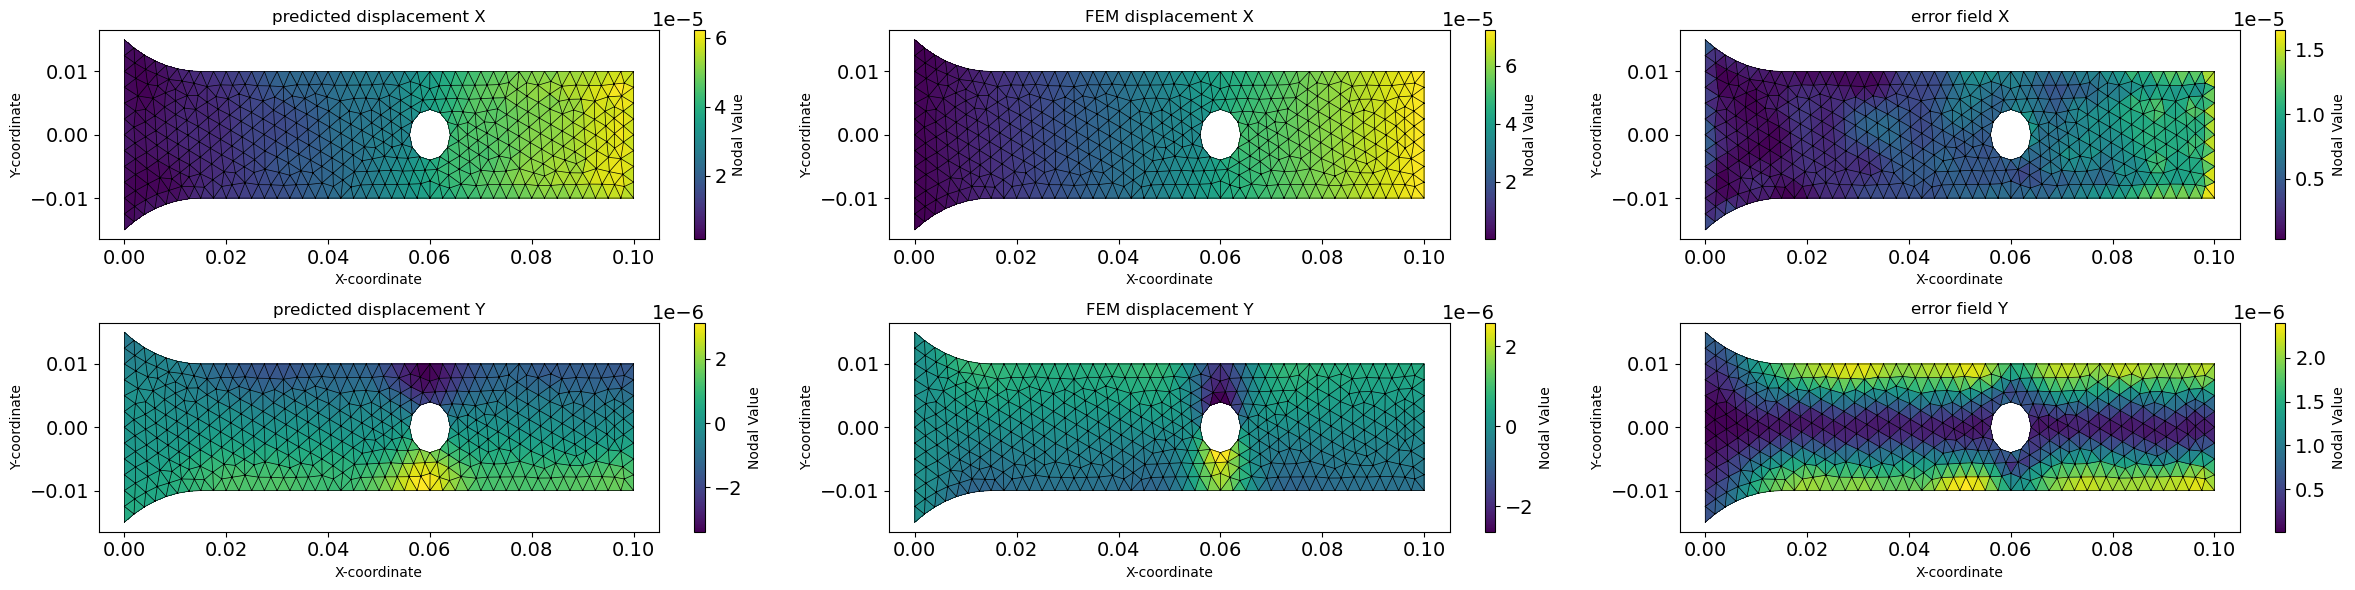

In [58]:
plot_result_compare_FEM(mesh_pos_sub, triangles_sub, params_predict, params_fem_deformation)

In [ ]:
def plot_result(data, matmean, matstd, predictions) :
    # Get node coordinates
    nodes = data.mesh_pos.cpu().detach().numpy()  # Extract the x, y coordinates (for 2D)
    predictions_plot = predictions.cpu().detach().numpy()
    plotdata = {"predicted displacement" : predictions_plot, "ground truth displacement": data.gt_displacement.cpu(), "error field" : torch.abs(predictions - data.gt_displacement).cpu().detach().numpy()}
    # Get connectivity for triangular elements
    normalized_mat_params = data.material_params[0].cpu() 
    material_parameters = normalized_mat_params * matstd + matmean
    # Plotting
    triangulation = tri.Triangulation(nodes[:, 0], nodes[:, 1], data.triangles.cpu())

    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(24, 6))  # 2 row, 3 columns

    # First subplot
    for key, v in plotdata.items() :
        for j in range(2) :
            i = list(plotdata.keys()).index(key)
            if key != "error field" :
                im = axes[j][i].tripcolor(triangulation, plotdata[key][:, j], shading='flat', cmap='viridis')
            else :
                im = axes[j][i].tripcolor(triangulation, plotdata[key][:, j], shading='flat', cmap='viridis')
            axes[j][i].triplot(triangulation, color='black', linewidth=0.5)
            if j == 0 :
                axes[j][i].set_title(f"{key} X")
            else :
                axes[j][i].set_title(f"{key} Y")
            axes[j][i].set_xlabel("X-coordinate")
            axes[j][i].set_ylabel("Y-coordinate")
            fig.colorbar(im, ax=axes[j][i], orientation='vertical', label="Nodal Value")
    fig.suptitle(material_parameters.detach().numpy(), fontsize=16)
    plt.tight_layout()
    plt.show()

In [17]:
predict_interpolate = model._output_normalizer.inverse(normalized_predict_interpolate)
predict_extrapolate = model._output_normalizer.inverse(normalized_predict_extrapolate)

In [18]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
def plot_result(data, matmean, matstd, predictions) :
    # Get node coordinates
    nodes = data.mesh_pos.cpu().detach().numpy()  # Extract the x, y coordinates (for 2D)
    predictions_plot = predictions.cpu().detach().numpy()
    plotdata = {"predicted displacement" : predictions_plot, "ground truth displacement": data.gt_displacement.cpu(), "error field" : torch.abs(predictions - data.gt_displacement).cpu().detach().numpy()}
    # Get connectivity for triangular elements
    normalized_mat_params = data.material_params[0].cpu() 
    material_parameters = normalized_mat_params * matstd + matmean
    # Plotting
    triangulation = tri.Triangulation(nodes[:, 0], nodes[:, 1], data.triangles.cpu())

    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(24, 6))  # 2 row, 3 columns

    # First subplot
    for key, v in plotdata.items() :
        for j in range(2) :
            i = list(plotdata.keys()).index(key)
            if key != "error field" :
                im = axes[j][i].tripcolor(triangulation, plotdata[key][:, j], shading='flat', cmap='viridis')
            else :
                im = axes[j][i].tripcolor(triangulation, plotdata[key][:, j], shading='flat', cmap='viridis')
            axes[j][i].triplot(triangulation, color='black', linewidth=0.5)
            if j == 0 :
                axes[j][i].set_title(f"{key} X")
            else :
                axes[j][i].set_title(f"{key} Y")
            axes[j][i].set_xlabel("X-coordinate")
            axes[j][i].set_ylabel("Y-coordinate")
            fig.colorbar(im, ax=axes[j][i], orientation='vertical', label="Nodal Value")
    fig.suptitle(material_parameters.detach().numpy(), fontsize=16)
    plt.tight_layout()
    plt.show()


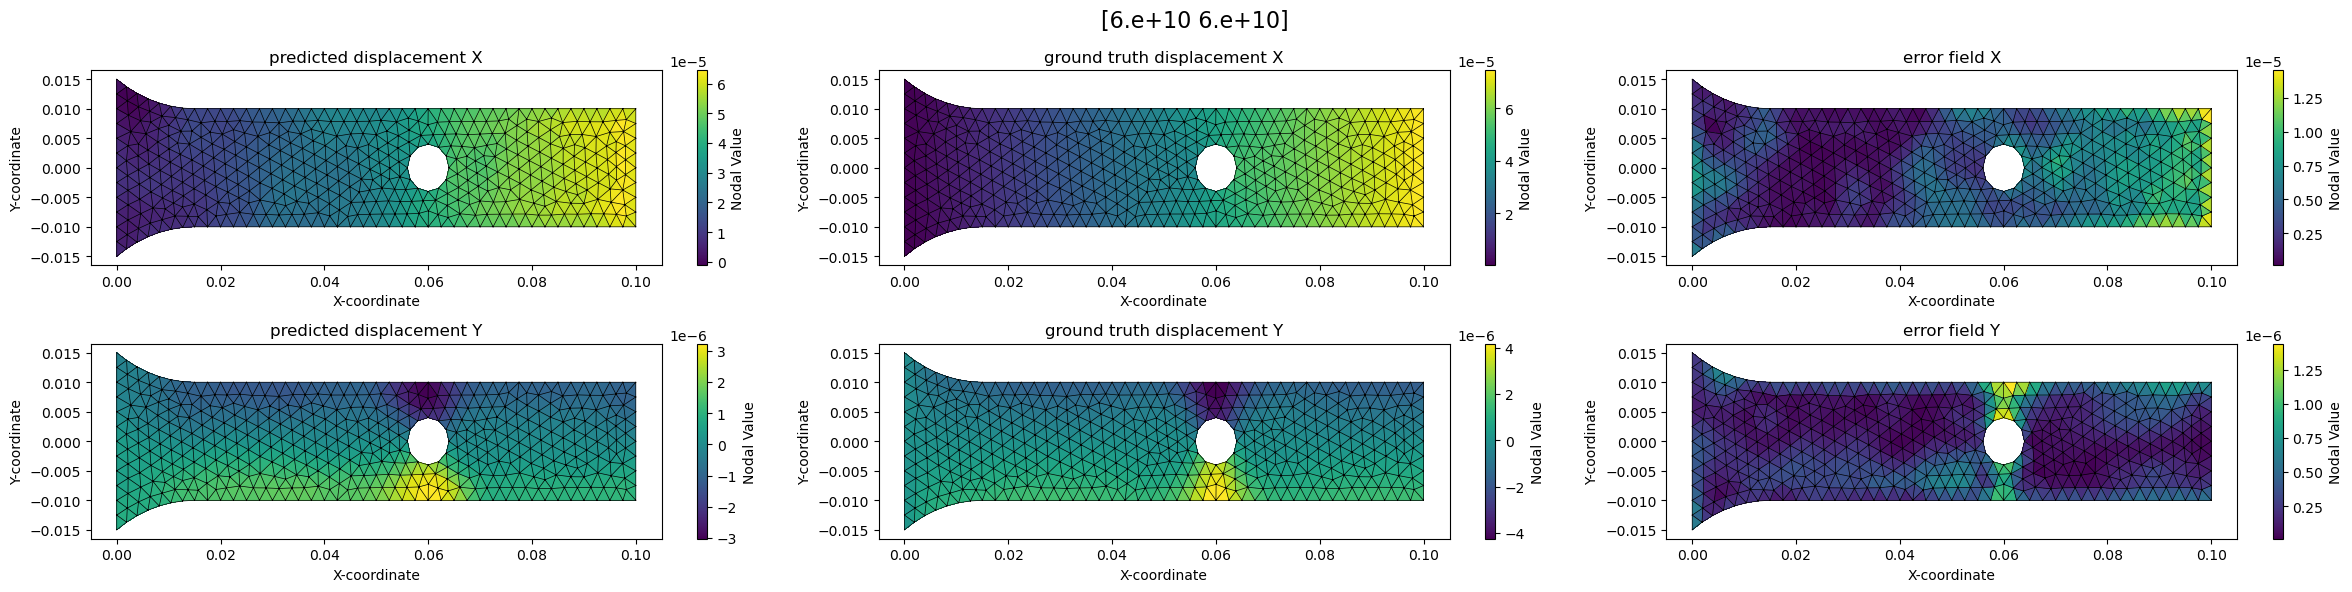

In [19]:
plot_result(data_interpolate, material_mean, material_std, predict_interpolate)

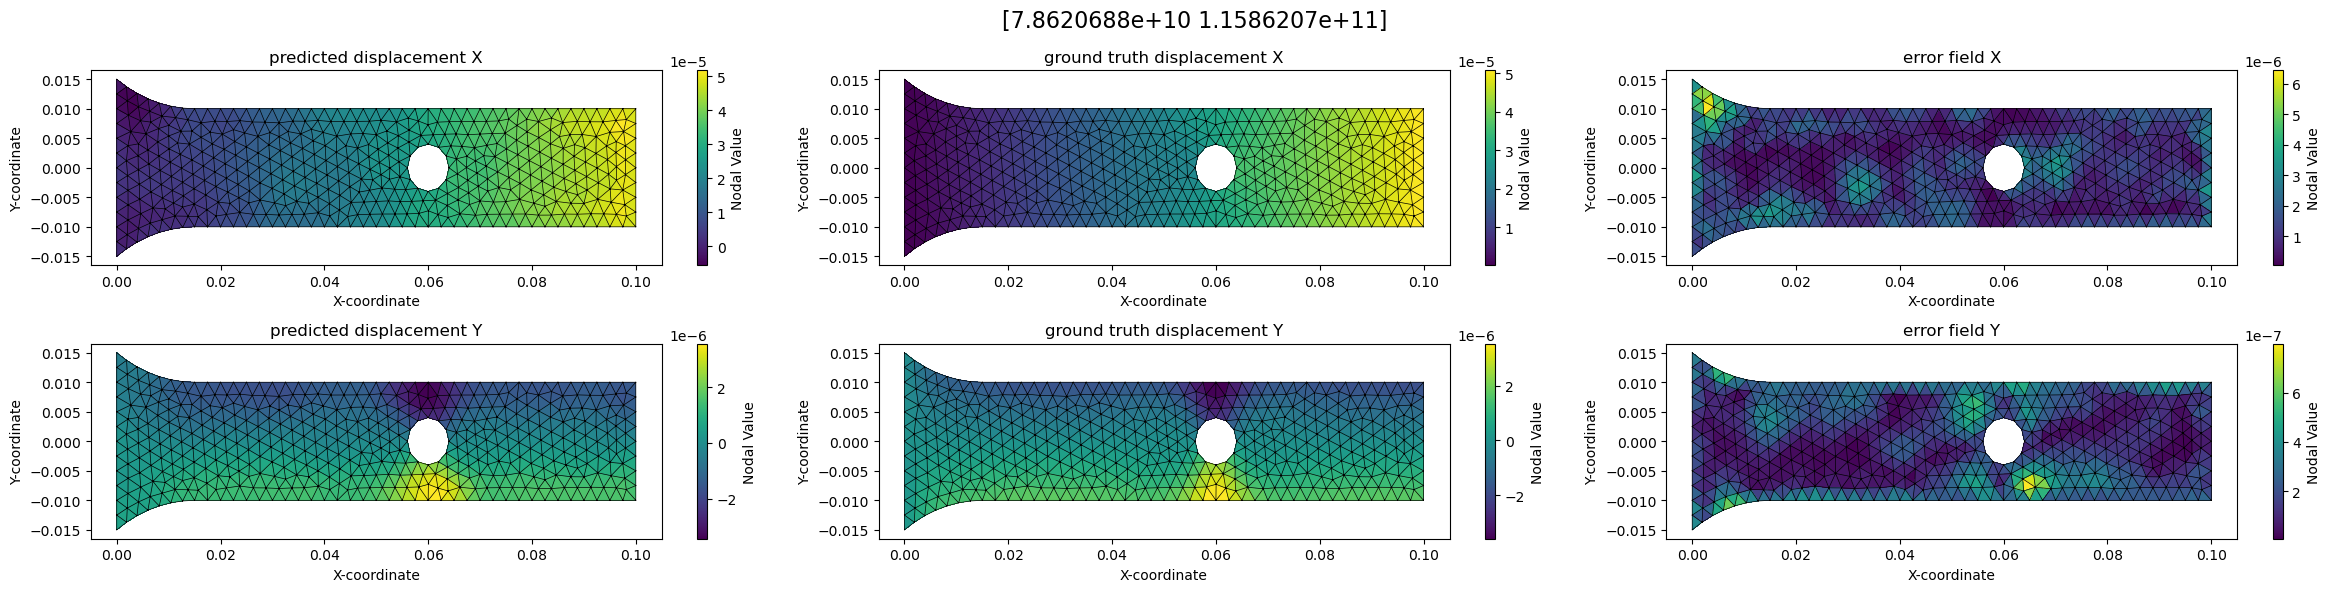

In [21]:
plot_result(data_extrapolate, material_mean, material_std, predict_extrapolate)

In [22]:
finer_mesh_data = preprocessing(dataset[900], dataset.meta, False)

edge_index_finer = finer_mesh_data.edge_index.to(device)
material_params_finer = finer_mesh_data.material_params.to(device)

/home/narupanta/ADDMM/surrogate_model/core/datasetclass.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  triangles = torch.tensor(torch.tensor(data['node_connectivity']))


In [23]:
normalized_finer_mesh_predict = model.decode(latent_space, edge_index_finer, material_params_finer).squeeze()
finer_mesh_predict = model._output_normalizer.inverse(normalized_finer_mesh_predict)

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 467 but got size 2549 for tensor number 1 in the list.

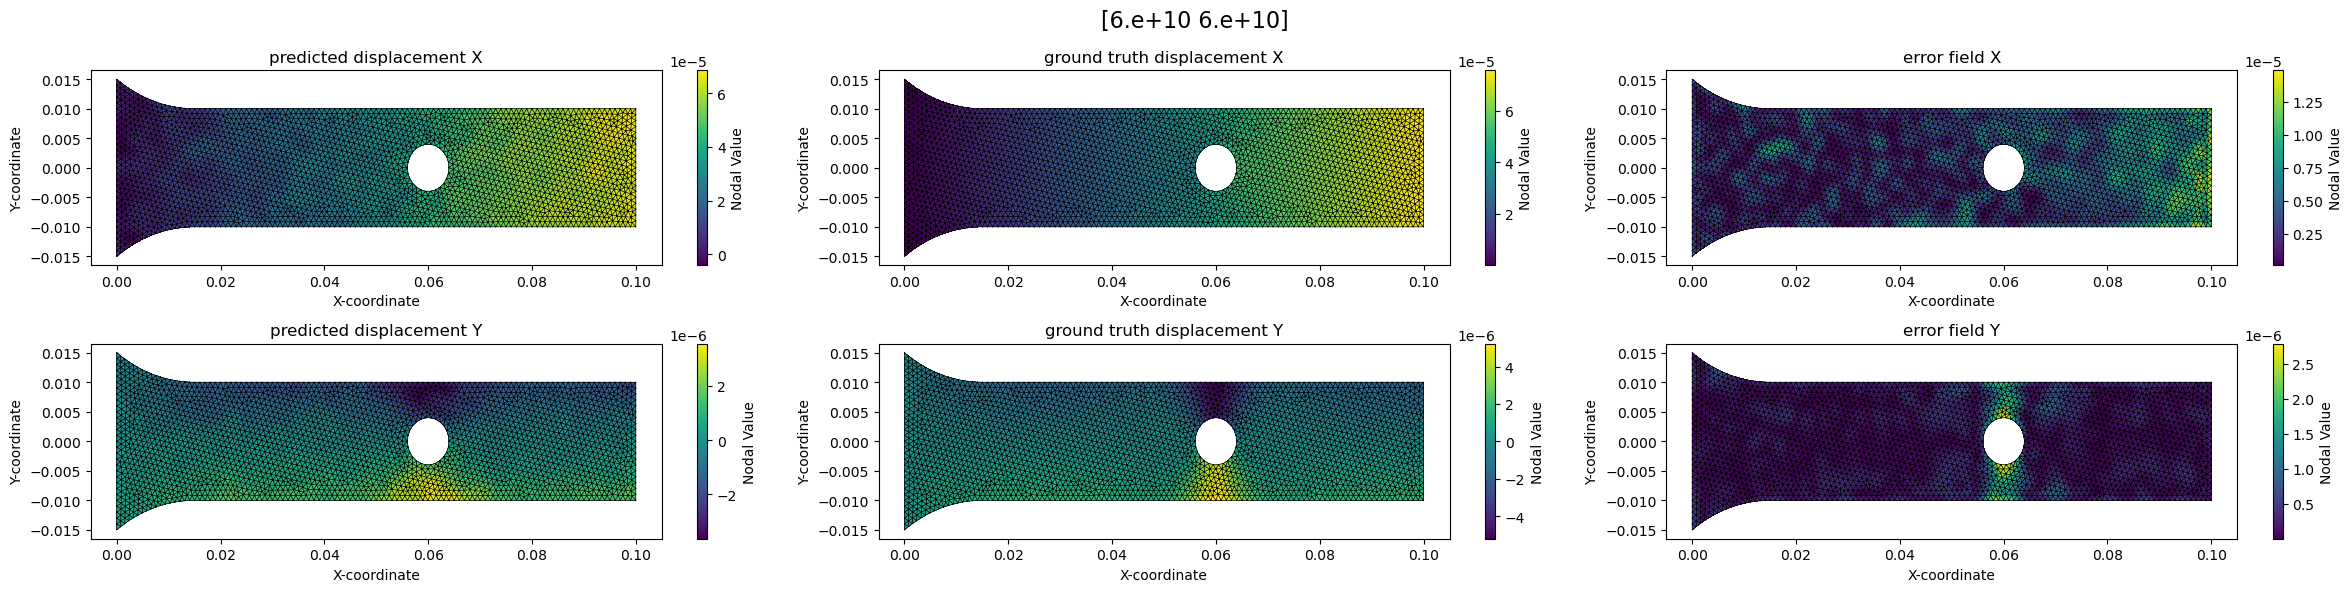

In [35]:
plot_result(finer_mesh_data, material_mean, material_std, finer_mesh_predict)

In [5]:
for i, data in enumerate(prep_dataset) :
    if data.mesh_pos.shape[0] > 467 :
        print(i)

900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
